<div dir="rtl" align="center">
<font face="XB Zar" size=5>
    <font face="IranNastaliq" size=5>
      به نام خدا
    </font>
    <br>
    <font size=3>
      دانشگاه صنعتی شریف - دانشکده مهندسی کامپیوتر
    </font>
    <br>
    <font color=blue size=5>
      مقدمه‌ای بر یادگیری ماشین
    </font>
    <br>
    <hr/>
    <font color=red size=6>
      فصل هفتم: Encoder, Decoder
    </font>
    <br>
       نویسندگان:‌ علیرضا دهقانپور فراشاه، مهدی سلمانی
    <hr>
<br>
  <div align="right">
  <font color="red" size=5>فهرست مطالب</font>
	<ul>
    <li>
        <a href='#intro'>
        مقدمه
    </a>
		</li>
		<li>
      <a href="#model">
       آشنایی با مدل
      </a>
    </li>
    <li>
      <a href="#training">
       آموزش مدل
      </a>
    </li>
    <li>
      <a href="#inference">
       نحوه خروجی گرفتن با داده تست
      </a>
    </li>
    </li>
    </div>
</font>
</div>


  <div dir=rtl id="intro">
  <font face="XB Zar" size=4>
      <font color="red" size=5>
        مقدمه
      </font>
<img src="https://static.packt-cdn.com/products/9781788624336/graphics/69abba8d-f902-43a9-8701-684941d1baf2.png" width="500">

</font>
</div>

In [1]:
from random import randint
from numpy import array
from numpy import argmax
import keras.backend as K
from tensorflow.keras import models
from numpy import array_equal
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

In [6]:

n_timesteps_in =   4

n_features = 10   

train_size= 5000
test_size = 100  


LSTMoutputDimension = 16


  <div dir=rtl id="model">
  <font face="XB Zar" size=4>
      <font color="red" size=5>
        آشنایی با مدل
      </font>
      <hr />
        در این بخش میخواهیم ستون 
  </font>
  </div>

In [3]:
# TRAINING WITH TEACHER FORCING
# Define an input sequence and process it.
encoder_inputs= Input(shape=(n_timesteps_in, n_features))
encoder_lstm=LSTM(LSTMoutputDimension, return_state=True)
LSTM_outputs, state_h, state_c = encoder_lstm(encoder_inputs)


# We discard `LSTM_outputs` and only keep the other states.
encoder_states = [state_h, state_c]



decoder_inputs = Input(shape=(None, n_features), name='decoder_inputs')
decoder_lstm = LSTM(LSTMoutputDimension, return_sequences=True, return_state=True, name='decoder_lstm')

# Set up the decoder, using `context vector` as initial state.
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

#complete the decoder model by adding a Dense layer with Softmax activation function 
#for prediction of the next output
#Dense layer will output one-hot encoded representation as we did for input
#Therefore, we will use n_features number of neurons
decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

# put together
model_encoder_training = Model([encoder_inputs, decoder_inputs], decoder_outputs, name='model_encoder_training')

Model: "model_encoder_training"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 10)]      0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None, 10)]   0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 16),         1728        ['input_1[0][0]']                
                                 (None, 16),                                                      
                                 (None, 16)]                                                      
                                                                             

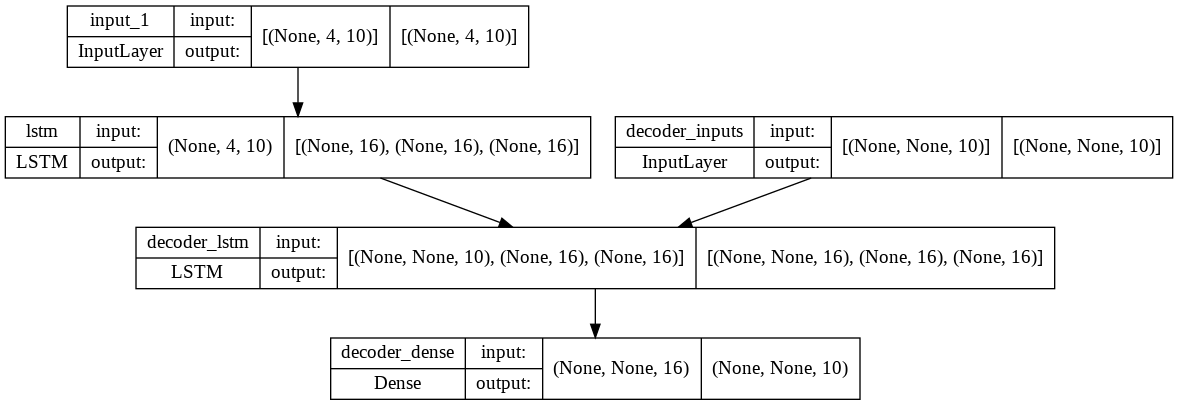

In [4]:
model_encoder_training.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_encoder_training.summary()
plot_model(model_encoder_training, show_shapes=True)


  <div dir=rtl id="preprocessing">
    <font face="XB Zar" size=4>
      <font color="red" size=5>آماده سازی دیتاست</font>
      <hr />  ‍
  </div>

In [5]:


# generate a sequence of random integers
def generate_sequence(length, n_unique):
	return [randint(1, n_unique-1) for _ in range(length)]

# one hot encode sequence
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
  return [argmax(vector) for vector in encoded_seq]

  # prepare encoder data for the Encoder-Decoder training
def get_encoder_triple(time_steps,vocabulary_size,verbose= False):
  # generate random sequence
  sequence_in = generate_sequence(time_steps, vocabulary_size)

  encoder_in = sequence_in.copy()
  

   
  

  decoder_out = sequence_in[::-1]
  
  decoder_in = decoder_out.copy()
  decoder_in.insert(0,0)
  decoder_in.pop()

  # one hot encode
  X_encoder_in = one_hot_encode(encoder_in, vocabulary_size)
  X_decoder_in = one_hot_encode(decoder_in, vocabulary_size)
  y_decoder_out = one_hot_encode(decoder_out, vocabulary_size)
  # reshape as 3D
  X_encoder_in = X_encoder_in.reshape((1, X_encoder_in.shape[0], X_encoder_in.shape[1]))
  X_decoder_in = X_decoder_in.reshape((1, X_decoder_in.shape[0], X_decoder_in.shape[1]))
  y_decoder_out = y_decoder_out.reshape((1, y_decoder_out.shape[0], y_decoder_out.shape[1]))

  if(verbose):
    print('\nSample X_encoder_in X_decoder_in and y_decoder_out')
    print('\nIn raw format:')
    print('X_encoder_in=%s, X_decoder_in=%s, y_decoder_out=%s' % 
          (one_hot_decode(X_encoder_in[0]), one_hot_decode(X_decoder_in[0]), 
           one_hot_decode(y_decoder_out[0])))
    print('\nIn one_hot_encoded format:')
    print('X_encoder_in=%s' % (X_encoder_in[0]))
    print('X_decoder_in=%s' % (X_decoder_in[0]))
    print('y_decoder_out=%s' % (y_decoder_out[0]))
  return [array(X_encoder_in), array(X_decoder_in), array(y_decoder_out)]


def create_encoder_dataset(train_size, test_size, time_steps,vocabulary_size, verbose= False):

  X_encoder_in = list()
  X_decoder_in = list()
  y_decoder_out = list()

  for _ in range(train_size):
    triple=get_encoder_triple(time_steps,vocabulary_size) 
    X_encoder_in.append(triple[0])
    X_decoder_in.append(triple[1])
    y_decoder_out.append(triple[2])

  X_encoder_in= array(X_encoder_in).squeeze()
  X_decoder_in= array(X_decoder_in).squeeze()
  y_decoder_out= array(y_decoder_out).squeeze()
  if(verbose):
    print('\nGenerated sequence datasets as follows')
    print('X_encoder_in.shape: ', X_encoder_in.shape)
    print('X_decoder_in.shape: ', X_decoder_in.shape)
    print('y_decoder_out.shape: ', y_decoder_out.shape)
    print('Sample sequences in raw format:')
    
    print('X_encoder_in: \n', one_hot_decode(X_encoder_in[0]))
    print('X_decoder_in: \n', one_hot_decode(X_decoder_in[0]))
    print('y_decoder_out: \n',one_hot_decode(y_decoder_out[0]))

    print('Sample sequences in one-hot encoded format:')
    print('X_encoder_in: \n', X_encoder_in[0])
    print('X_decoder_in: \n', X_decoder_in[0])
    print('y_decoder_out: \n', y_decoder_out[0])

  return X_encoder_in,X_decoder_in, y_decoder_out

In [7]:

encoder_input_data, decoder_input_data, decoder_predicted_data=\
create_encoder_dataset(train_size, test_size, n_timesteps_in,n_features , verbose=True)



Generated sequence datasets as follows
X_encoder_in.shape:  (5000, 4, 10)
X_decoder_in.shape:  (5000, 4, 10)
y_decoder_out.shape:  (5000, 4, 10)
Sample sequences in raw format:
X_encoder_in: 
 [7, 8, 8, 5]
X_decoder_in: 
 [0, 5, 8, 8]
y_decoder_out: 
 [5, 8, 8, 7]
Sample sequences in one-hot encoded format:
X_encoder_in: 
 [[0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 0]]
X_decoder_in: 
 [[1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0]]
y_decoder_out: 
 [[0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 0]]



  <div dir=rtl id="training">
    <font face="XB Zar" size=4>
      <font color="red" size=5>آموزش مدل</font>
      <hr />  ‍
  </div>

In [8]:
model_encoder_training.fit([encoder_input_data, decoder_input_data], decoder_predicted_data,
          batch_size=32,
          epochs=5,
          validation_split=0.2)

Epoch 1/5
125/125 [==============================] - 5s 12ms/step - loss: 2.2030 - accuracy: 0.2045 - val_loss: 2.0180 - val_accuracy: 0.3335
Epoch 2/5
125/125 [==============================] - 1s 5ms/step - loss: 1.7671 - accuracy: 0.3681 - val_loss: 1.5500 - val_accuracy: 0.4130
Epoch 3/5
125/125 [==============================] - 1s 5ms/step - loss: 1.4002 - accuracy: 0.4714 - val_loss: 1.2412 - val_accuracy: 0.5415
Epoch 4/5
125/125 [==============================] - 1s 6ms/step - loss: 1.0813 - accuracy: 0.6413 - val_loss: 0.9169 - val_accuracy: 0.7515
Epoch 5/5
125/125 [==============================] - 1s 5ms/step - loss: 0.7745 - accuracy: 0.8286 - val_loss: 0.6464 - val_accuracy: 0.8825



  <div dir=rtl id="inference">
    <font face="XB Zar" size=4>
      <font color="red" size=5>نحوه خروجی گرفتن روی داده تست</font>
      <hr />  ‍
  </div>

In [10]:
encoder_model = Model(encoder_inputs, encoder_states)

In [11]:
decoder_state_input_h = Input(shape=(LSTMoutputDimension,))
decoder_state_input_c = Input(shape=(LSTMoutputDimension,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [13]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, n_features))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, 0] = 1

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_seq = list()
    while not stop_condition:

        # in a loop
        # decode the input to a token/output prediction + required states for context vector
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # convert the token/output prediction to a token/output
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_digit = sampled_token_index
        # add the predicted token/output to output sequence
        decoded_seq.append(sampled_digit)
        

        # Exit condition: either hit max length
        # or find stop character.
        if (len(decoded_seq) == n_timesteps_in):
            stop_condition = True

        # Update the input target sequence (of length 1) 
        # with the predicted token/output 
        target_seq = np.zeros((1, 1, n_features))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update input states (context vector) 
        # with the ouputed states
        states_value = [h, c]

        # loop back.....
        
    # when loop exists return the output sequence
    return decoded_seq

In [14]:
print('Input \t\t\t  Expected  \t   Predicted \t\tT/F')
correct =0 
sampleNo =  10
for sample in range(0,sampleNo):
  predicted= decode_sequence(encoder_input_data[sample].reshape(1,n_timesteps_in,n_features))
  if (one_hot_decode(decoder_predicted_data[sample])== predicted):
    correct+=1
  print( one_hot_decode(encoder_input_data[sample]), '\t\t', 
        one_hot_decode(decoder_predicted_data[sample]),'\t', predicted,
        '\t\t',one_hot_decode(decoder_predicted_data[sample])== predicted)
print('Accuracy: ', correct/sampleNo)

Input 			  Expected  	   Predicted 		T/F
[7, 8, 8, 5] 		 [5, 8, 8, 7] 	 [8, 5, 8, 7] 		 False
[5, 7, 3, 9] 		 [9, 3, 7, 5] 	 [9, 3, 7, 5] 		 True
[2, 9, 3, 1] 		 [1, 3, 9, 2] 	 [1, 3, 9, 2] 		 True
[8, 4, 7, 2] 		 [2, 7, 4, 8] 	 [2, 7, 4, 8] 		 True
[8, 4, 8, 4] 		 [4, 8, 4, 8] 	 [4, 8, 8, 4] 		 False
[4, 4, 3, 9] 		 [9, 3, 4, 4] 	 [9, 4, 3, 4] 		 False
[6, 7, 8, 2] 		 [2, 8, 7, 6] 	 [2, 8, 7, 6] 		 True
[2, 8, 8, 3] 		 [3, 8, 8, 2] 	 [8, 3, 2, 8] 		 False
[3, 3, 3, 2] 		 [2, 3, 3, 3] 	 [3, 2, 3, 3] 		 False
[6, 8, 9, 8] 		 [8, 9, 8, 6] 	 [8, 9, 8, 6] 		 True
Accuracy:  0.5
